# NWFZ Population over time

## Sources

- Population Data (Total Population on 01 July): United Nations, Department of Economic and Social Affairs, Population Division (2022). World Population Prospects 2022, Online Edition. Retrieved from [population.un.org/wpp/Download/Standard/CSV/](https://population.un.org/wpp/Download/Standard/CSV/)


In [618]:
import pandas as pd
import matplotlib.pyplot as plt
population_raw = pd.read_csv("./tmp/WPP2022_TotalPopulationBySex.csv")
nwfz_states = pd.read_csv("./data/nwfz_states.csv")

/var/folders/7l/mfh_67fs1_j6zj997d0xy1cr0000gn/T/ipykernel_42386/2198810838.py:3: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  population_raw = pd.read_csv("./tmp/WPP2022_TotalPopulationBySex.csv")


In [703]:
nwfz_states.in_force = nwfz_states.in_force.astype(int, copy=False)

pops = population_raw.loc[
	(population_raw["Variant"] == "Medium") &
	(population_raw["LocTypeName"] == "Country/Area")
	& (population_raw["ISO3_code"])
	& (population_raw["Time"] <= 2024)
].copy()

def set_is_nwfz(row):
	if ((row.ISO3_code == "MNG") & (row.Time >= 2000)):
		return True
	if row.ISO3_code in list(nwfz_states["iso3"]):
		if row.Time > nwfz_states.loc[nwfz_states["iso3"] == row.ISO3_code, 'in_force'].values[0]:
			return True
		return False
	else:
		return False

def set_adjPop(row):
	if row.is_nwfz == True:
		return row.PopTotal
	else:
		return 0
	
pops["is_nwfz"] = pops.apply(set_is_nwfz, axis=1)
pops["adjPop"] = pops.apply(set_adjPop, axis=1)

pops = pops.pivot(
	index=["Time"],
	columns=["Location"],
	values=["PopTotal", "adjPop"]
)

pops["total"] = pops["PopTotal"].sum(axis=1)
pops["nwfz_total"] = pops["adjPop"].sum(axis=1)
pops["ratio"]= pops["nwfz_total"].divide(pops["total"])

          Time        total   nwfz_total     ratio
Location                                          
0         1950  2499322.166        0.000  0.000000
1         1951  2543130.378        0.000  0.000000
2         1952  2590270.906        0.000  0.000000
3         1953  2640278.794        0.000  0.000000
4         1954  2691979.337        0.000  0.000000
..         ...          ...          ...       ...
70        2020  7840952.880  2784854.246  0.355168
71        2021  7909295.146  2829344.630  0.357724
72        2022  7975105.157  2873421.169  0.360299
73        2023  8045311.446  2919057.300  0.362827
74        2024  8118835.991  2965815.301  0.365301

[75 rows x 4 columns]


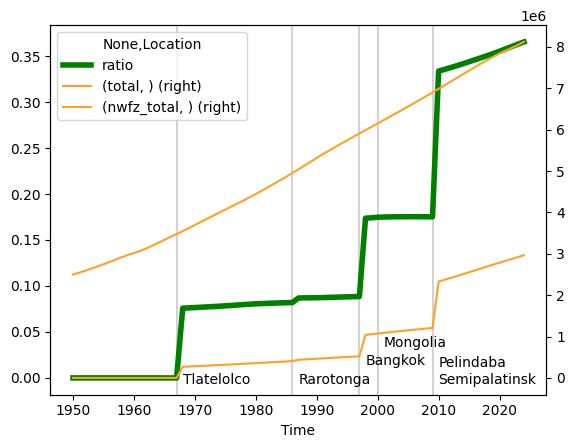

In [713]:
# Plot

t = pops.loc[:, ["total", 'nwfz_total', 'ratio']].reset_index()

print(t)

labels = pd.DataFrame([
	{"year": 1967, "text": "Tlatelolco", "yo": 0},
	{"year": 1986, "text": "Rarotonga", "yo": 0},
	{"year": 1997, "text": "Bangkok", "yo": .05},
	{"year": 2000, "text": "Mongolia", "yo": .1},
	{"year": 2009, "text": "Pelindaba\nSemipalatinsk", "yo": 0},
])
ax = t.plot(kind="line", x="Time",  y="ratio" ,color="green", lw=4,zorder=100)
t.plot(ax=ax,kind="line",secondary_y=True,x="Time", y=["total", 'nwfz_total'], color="#ffa127", zorder=0)

for index, l in labels.iterrows():
	ax.axvline(x=l["year"], color="lightgray", zorder=-10)
	ax.annotate(
		text=l["text"],
		xy=(l["year"], t.loc[t["Time"] == l["year"]].ratio.values[0]),
		xytext=(l["year"] + 1,.03 + l["yo"]),
		textcoords=("data","axes fraction"),
		zorder=200
		)
